# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Имеются исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»).

Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:
- Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные представлены в 14 колонках, содержится 10тыс записей,  одной колонке Tenure есть пропущенные строки. В 8 колонках содержатся целочисленные значения, в в 3 столбцах - данные типа object, в 3 столбцах - числа с плавающей запятой.

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
print(df[df['Tenure'].isnull()].count())

RowNumber          909
CustomerId         909
Surname            909
CreditScore        909
Geography          909
Gender             909
Age                909
Tenure               0
Balance            909
NumOfProducts      909
HasCrCard          909
IsActiveMember     909
EstimatedSalary    909
Exited             909
dtype: int64


In [6]:
print(df['Tenure'].median())
print(df['Tenure'].mean())

5.0
4.997690023099769


In [7]:
#заменяю пропущенные значения в столбце "Tenure" на медианное значение
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [8]:
#Проверю соотношение классов в целевом признаке
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [9]:
class_frequency = df['Exited'].value_counts(normalize=True)
print(class_frequency)

0    0.7963
1    0.2037
Name: Exited, dtype: float64


В данной выборке у нас только 2037 наблюдений класса 1, тогда как остальные 7963 — класса 0. 

In [10]:
df = df.drop(columns=['RowNumber', 'Surname', 'CustomerId'])

# 2. Исследование задачи

### Проверяю 3 модели :
- Случайный лес
- Дерево решений
- Логистическая регрессия

In [11]:
df['Gender'] = pd.get_dummies(df['Gender'], drop_first=True)
df['Geography'] = pd.get_dummies(df['Geography'])

In [12]:
#Разобью данные на выборки
df_train, df_valid = train_test_split(df, test_size=0.20, random_state=12345) 

features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited'] 

In [13]:
df_train, df_test = train_test_split(df_train, test_size=0.20, random_state=12345) 

features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited'] 

### Модель "Логистическая регрессия"

In [14]:
LR_model = LogisticRegression(random_state=12345)  
LR_model.fit(features_train, target_train) 
LR_predictions_valid= LR_model.predict(features_valid)
LR_result = f1_score(target_valid, LR_predictions_valid) 

print("F1-мера модели логистической регрессии на валидационной выборке:", LR_result)

F1-мера модели логистической регрессии на валидационной выборке: 0.09856262833675564


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Модель "Дерево решений"

In [15]:
DR_best_model = None
DR_best_result = 0
for depth in range(1, 6):
    DR_model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    DR_model.fit(features_train, target_train) 
    DR_predictions_valid= DR_model.predict(features_valid) 
    DR_result = f1_score(target_valid, DR_predictions_valid) 
    if DR_result > DR_best_result:
        DR_best_model = DR_model
        DR_best_result = DR_result
        DR_best_depth = depth
        
print("F1-мера наилучшей модели на валидационной выборке:", DR_best_result)
print("Наилучшее значение гиперпараметра:", DR_best_depth)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-мера наилучшей модели на валидационной выборке: 0.5478645066273933
Наилучшее значение гиперпараметра: 5


### Модель "Случайный лес"

In [16]:
SL_best_model = None
SL_best_result = 0
SL_best_est = 0
SL_best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        SL_model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # инициализируйте модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
        SL_model.fit(features_train, target_train) # обучите модель на тренировочной выборке
        SL_predictions_valid = SL_model.predict(features_valid) # получите предсказания модели на валидационной выборке
        SL_result = f1_score(target_valid, SL_predictions_valid)  # посчитайте качество модели
        if SL_result > SL_best_result:
            SL_best_model = SL_model
            SL_best_result = SL_result
            SL_best_est = est
            SL_best_depth = depth

print("F1-мера наилучшей модели:", SL_best_result, "Количество деревьев:", SL_best_est, "Максимальная глубина:", depth)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

F1-мера наилучшей модели: 0.5276073619631902 Количество деревьев: 20 Максимальная глубина: 10


### Вывод: 

Модель случайный лес показала лучшее значение f1 равное 0.52. 

Далее буду работать с этой моделью. Посчитаю основыне метрики для этой модели.

In [17]:
#Матрица ошибок
print(confusion_matrix(target_valid, SL_predictions_valid)) 

[[1525   48]
 [ 260  167]]


In [18]:
#F1-мера
f1_score(target_valid, SL_predictions_valid)

0.5202492211838006

In [19]:
SL_result_test = 0
SL_model = RandomForestClassifier(random_state=12345, n_estimators=SL_best_est, max_depth=SL_best_depth) 
SL_model.fit(features_train, target_train) 
SL_predictions_valid = SL_model.predict(features_valid)
SL_predictions_test = SL_model.predict(features_test) 
SL_result_test = f1_score(target_test, SL_predictions_test)  
 
print("F1-мера наилучшей модели на тестовой выборке:", SL_result_test)

F1-мера наилучшей модели на тестовой выборке: 0.5344827586206897


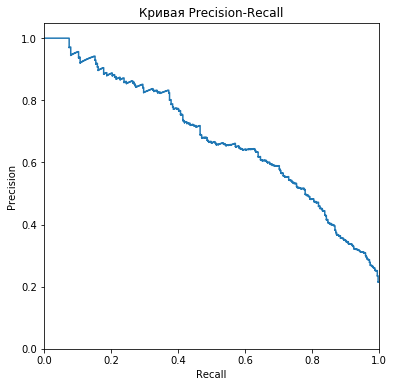

In [20]:
probabilities_valid = SL_model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

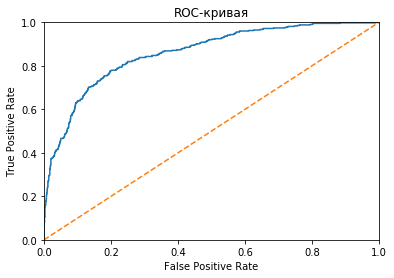

In [21]:
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

# 3. Борьба с дисбалансом

Применю несколько техник борьбы с дисбалансом.

#### OHE кодирование

In [22]:
#Дамми-ловушка
data_ohe = pd.get_dummies(df, drop_first=True)

In [23]:
#Разобью данные на выборки

df_train, df_valid = train_test_split(data_ohe, test_size=0.20, random_state=12345) 

features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited'] 

In [24]:
df_train, df_test = train_test_split(df_train, test_size=0.20, random_state=12345) 

features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited'] 

#### Масштабирвоание признаков

In [25]:
#Масштабирование признаков
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#### Уменьшение выборки

In [26]:
#Уменьшение выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.75)

In [27]:
SL_best_result = 0
SL_best_est = 0
SL_best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        SL_model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced') # инициализируйте модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
        SL_model.fit(features_downsampled, target_downsampled) # обучите модель на тренировочной выборке
        SL_predictions_valid = SL_model.predict(features_valid) # получите предсказания модели на валидационной выборке
        SL_result = f1_score(target_valid, SL_predictions_valid) 
        if SL_result > SL_best_result:
            SL_best_result = SL_result
            SL_best_est = est
            SL_best_depth = depth

print("F1-мера наилучшей модели:", SL_best_result, "Количество деревьев:", SL_best_est, "Максимальная глубина:", depth)

F1-мера наилучшей модели: 0.6308169596690796 Количество деревьев: 40 Максимальная глубина: 10


In [28]:
#Матрица ошибок
print(confusion_matrix(target_valid, SL_predictions_valid)) 

[[1386  187]
 [ 164  263]]


In [29]:
#Вычисляю полноту модели
print(recall_score(target_valid, SL_predictions_valid))

0.6159250585480094


In [30]:
#Вычисляю точность модели
print(precision_score(target_valid, SL_predictions_valid))

0.5844444444444444


In [31]:
#F1-мера
f1_score(target_valid, SL_predictions_valid)

0.5997719498289624

# 4. Тестирование модели

In [32]:
SL_result_test = 0
SL_model = RandomForestClassifier(random_state=12345, n_estimators=SL_best_est, max_depth=SL_best_depth, class_weight='balanced') # инициализируйте модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
SL_model.fit(features_downsampled, target_downsampled) 

SL_predictions_test = SL_model.predict(features_test) 
SL_result_test = f1_score(target_test, SL_predictions_test)  
 
print("F1-мера наилучшей модели на тестовой выборке:", SL_result_test)

F1-мера наилучшей модели на тестовой выборке: 0.5934379457917262


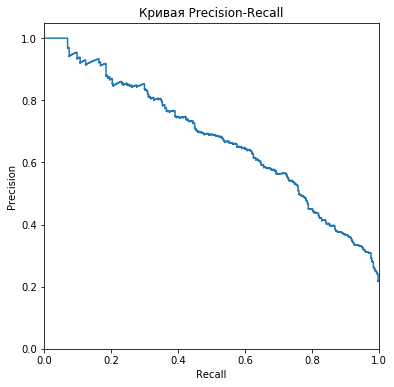

In [33]:
probabilities_valid = SL_model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

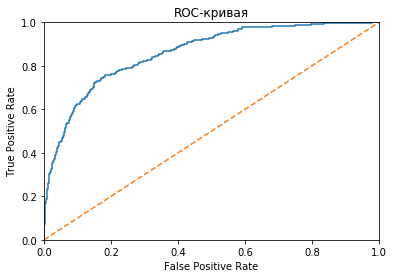

In [34]:
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [35]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8608113198277133


### Вывод: 

В этом проекте проведена предобработка данных и получена модель, которая предсказывает уйдет клиент из Банка или нет. 
- F1-мера(среднее гармоническое полноты и точности) на тестовой выборке = 0.59. 
- Построена кривая ошибок.
- Посчитано значение AUC-ROC = 0.86.